In [109]:
import numpy as np
import networkx as nx
import re
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

epsilon = 1e-3

In [2]:
# 生成一堆随机点
n_points = 2000
points = np.random.randn(n_points, 2)

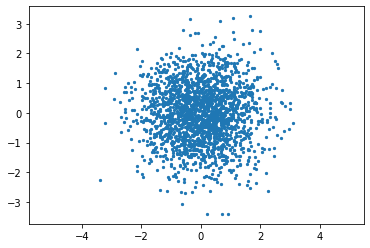

In [3]:
plt.axis("equal")
plt.scatter(points[:, 0], points[:, 1], s=5.0)

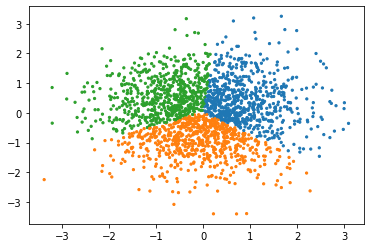

In [4]:
# K-均值法
clusters_centroid = 3

# 1. 首先，随机挑选中心点位置
# 2. 然后看每个点离哪个中心点更近，并把它们归到那个类当中
# 3. 根据聚好的类生成新的三个中心点
# 4. 重复直到满意为止
centroids = np.random.randn(clusters_centroid, 2)
p_clusters = np.zeros((n_points, 1))

for i in range(0, 10):
    # 用来追踪啥时候该停止
    stop_counter = 0
    
    for p_idx, p in enumerate(points):
        closest_dist = 0
        closest_idx = -1
        for k_idx, k in enumerate(centroids):
            dist = np.linalg.norm(p - k)
            if closest_idx == -1 or dist < closest_dist:
                closest_dist = dist
                closest_idx = k_idx
        if closest_idx == -1:
            raise Error("错误! 有个点没有分到类")
        p_clusters[p_idx] = closest_idx

    # 计算新的中心点位
    for k_idx, k in enumerate(centroids):
        points_k = points[(p_clusters == k_idx).flatten()]
        # 检查是不是有中心点没分到点
        if len(points_k) == 0:
            centroids = np.random.randn(clusters_centroid, 2)
            break
        new_centroid = np.zeros((1, 2))
        for p in points_k:
            new_centroid += p
        new_centroid /= len(points_k)
        # 检查中心点是不是接近不变
        if np.linalg.norm(new_centroid - k) < epsilon:
            stop_counter += 1
        centroids[k_idx] = new_centroid
        
    if stop_counter == len(centroids):
        break

# 画出结果
primitive_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
colors = [primitive_colors[int(x[0])] for x in p_clusters]
plt.scatter(points[:, 0], points[:, 1], s=5.0, c=colors)

In [58]:
# 接下来是 DBSCAN - 生成一堆聚在一起的点
clusters_dbscan = 3
n_points = 1000
n_outliers = int(n_points / 10)
points = np.zeros((n_points, 2))
n_chunk = int((n_points - n_outliers) / 3)
centers = []
for i in range(0, clusters_dbscan):
    while True:
        center = np.random.randn(1, 2)
        for c in centers:
            if np.linalg.norm(center - c) < 2.0:
                break
        else:
            centers.append(center)
            break
    for j in range(0, n_chunk):
        # 随机生成一个方向和距离
        dist = (np.random.rand() * 2.0 - 1.0) * 1.0
        direction = np.random.randn(1, 2)
        direction /= np.linalg.norm(direction)
        points[i * n_chunk + j] = center + dist * direction
for i in range(0, n_outliers):
    points[clusters_dbscan * n_chunk + i] = np.random.randn(1, 2)

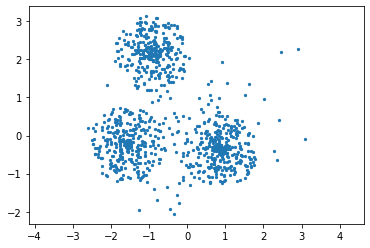

In [59]:
plt.axis("equal")
plt.scatter(points[:, 0], points[:, 1], s=5.0)

In [60]:
# DBSCAN
# k = 0 代表离群
k = 0
labels = np.zeros((n_points, 1))
core_req = 4
delta = 0.18

def get_neighbors(p1, dist_req):
    dists = np.array([np.linalg.norm(p1 - p2) for p2 in points])
    ret = dists < dist_req
    return np.where(ret)[0]

# 1. 如果有标签，跳过
# 2. 如果没有标签，查找邻居 - 是不是在 core_req 个邻居以内（包括自身）?
# 3. 如果是，检查邻居的邻居，是否满足 core_req。如果是，把邻居的邻居也加到检查列表当中。
# 4. 一直循环直到满足这些为止。
for i, p in enumerate(points):
    if labels[i] != 0:
        continue
    neighbors = get_neighbors(p, delta)
    if len(neighbors) >= core_req:
        k += 1
        labels[i] = k
        while len(neighbors) > 0:
            neighbor = neighbors[0]
            neighbors = np.delete(neighbors, 0)
            if neighbor == i or labels[neighbor] != 0:
                continue
            labels[neighbor] = k
            neighbors_neighbors = get_neighbors(points[neighbor], delta)
            if len(neighbors_neighbors) >= core_req:
                neighbors = np.union1d(neighbors, neighbors_neighbors)

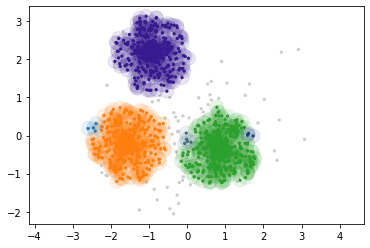

In [61]:
# 画出结果
primitive_colors = ["#cccccc", "#1f77b4", "#ff7f0e", "#2ca02c", "#1a437b", "#426f7c", "#381a90", "#1f1f21"]
colors = [primitive_colors[int(x[0])] for x in labels]

fig, ax = plt.subplots()
ax.axis("equal")
ax.scatter(points[:, 0], points[:, 1], s=5.0, c=colors)
for i, p in enumerate(points):
    if labels[i] == 0:
        continue
    circle = plt.Circle(p, delta, alpha=0.1, color=colors[i])
    ax.add_artist(circle)
plt.show()

In [36]:
# OPTICS 解决了 DBSCAN 的一大难题 - 在同一个数据集中对不同密度的聚类进行聚类。
# 所以先生成一些满足这个条件的点
clusters_dbscan = 2
n_points = 1000
n_outliers = int(n_points / 10)
points = np.zeros((n_points, 2))
n_chunk = int((n_points - n_outliers) / 3)
for i in range(0, clusters_dbscan):
    center = np.random.randn(1, 2)
    density = np.random.rand() * 2.0
    for j in range(0, n_chunk):
        # 随机生成一个方向和距离
        dist = 0.3 + (np.random.rand() * 2.0 - 1.0) * density
        direction = np.random.randn(1, 2)
        direction /= np.linalg.norm(direction)
        points[i * n_chunk + j] = center + dist * direction
for i in range(0, n_outliers):
    points[clusters_dbscan * n_chunk + i] = np.random.randn(1, 2)

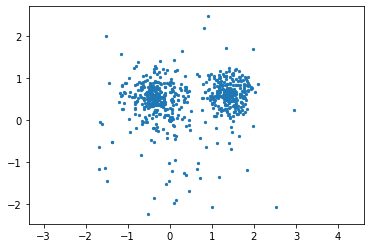

In [37]:
plt.axis("equal")
plt.scatter(points[:, 0], points[:, 1], s=5.0)

In [38]:
# 超级简单的优先级队列实现
class PriorityQueue:
    def __init__(self):
        self.queue = []
        
    def update(self, value, priority):
        for i, vp in enumerate(self.queue):
            if vp[0] == value:
                del self.queue[i]
                break
        for i, vp in enumerate(self.queue):
            if vp[1] > priority:
                self.queue.insert(i, (value, priority))
                break
        else:
            self.queue.append((value, priority))
            
    def pop(self):
        ret = self.queue[0][0]
        del self.queue[0]
        return ret
    
    def empty(self):
        return len(self.queue) == 0

In [39]:
# OPTICS
# k = 0 代表离群
k = 0
labels = np.zeros((n_points, 1))
core_req = 4
delta = 1.0

def get_neighbors(p1, dist_req):
    dists = np.array([np.linalg.norm(p1 - p2) for p2 in points])
    ret = dists < dist_req
    indexes = np.where(ret)[0]
    return indexes, dists[indexes]

def get_nth_smallest_idx(arr, idx):
    min_idxes = []
    bad = False
    ret_val = -1.0
    for i in range(0, idx + 1):
        if len(arr) == 0:
            bad = True
            break
        idx = np.argmin(arr)
        min_idxes.append(idx)
        ret_val = arr[idx]
        arr = np.delete(arr, idx)
    if bad:
        return None, -1.0
    ret = min_idxes[-1]
    for idx in min_idxes[:-1]:
        # 如果是在之前删走的，那就 +1 
        if idx <= ret:
            ret += 1
    return ret, ret_val

def update(p, core_dist, neighbors, seeds):
    for neighbor in neighbors:
        if labels[neighbor] != 0 or np.linalg.norm(p - points[neighbor]) < epsilon:
            continue
        reachability_dist = max(np.linalg.norm(points[neighbor] - p), core_dist)
        reachability_dists[neighbor] = reachability_dist
        seeds.update(neighbor, reachability_dist)
        
reachability_dists = np.zeros((n_points, 1))
output_points = []
output_reachabilities = []

# 1. 对每个未处理的点来说：
# 1.1 计算 "核心距离"，也就是每个点的第 core_req 个近邻居的的距离
# 1.2 若核心距离有定义，则这里可以发生集群。
# 2. 因此，新建一条优先级队列，并对邻居进行入队操作。
# 2.1 更新所有邻居的可到达距离
# 2.2 根据可到达距离对优先级队列内的成员进行相应的调整
for i, p in enumerate(points):
    if labels[i] != 0:
        continue
    neighbors, neighbors_dists = get_neighbors(p, delta)
    core_dist_idx, core_dist = get_nth_smallest_idx(neighbors_dists, core_req - 1)
    if core_dist_idx is not None:
        k += 1
        output_points.append(p)
        output_reachabilities.append(core_dist)
        labels[i] = k
        seeds = PriorityQueue()
        update(p, core_dist, neighbors, seeds)
        while not seeds.empty():
            q_index = seeds.pop()
            q = points[q_index]
            
            output_points.append(q)
            output_reachabilities.append(reachability_dists[q_index][0])

            neighbors, neighbors_dists = get_neighbors(q, delta)
            labels[q_index] = k
            core_dist_idx, core_dist = get_nth_smallest_idx(neighbors_dists, core_req - 1)
            if core_dist_idx is not None:
                update(q, core_dist, neighbors, seeds)

In [40]:
# 根据可到达性图动态进行分类
def optics_draw(threshold):
    fix, ax = plt.subplots()
    k = 1
    outliers = False
    
    draw_points = []
    draw_reachabilities = []
    output_color_skips = [0]
    count = 0
    for i in range(0, len(output_points)):
        if output_reachabilities[i] > threshold:
            if outliers is False:
                outliers = True
                points = []
            continue
        if outliers is True:
            output_color_skips.append(count)
            k += 1
            outliers = False
        draw_reachabilities.append(output_reachabilities[i])
        draw_points.append([output_points[i][0], output_points[i][1], k])
        count += 1
    output_color_skips.append(len(draw_points))
    
    # 绘制这一堆点
    ax.axis("equal")
    ax.scatter([x[0] for x in draw_points], [y[1] for y in draw_points], s=5.0, c=[c[2] for c in draw_points])
    plt.show()
    
    fig, ax = plt.subplots()
    output_color_skips.append(len(draw_reachabilities))
    for i in range(0, len(output_color_skips) - 1):
        ax.plot(np.arange(output_color_skips[i], output_color_skips[i + 1]), draw_reachabilities[output_color_skips[i]:output_color_skips[i + 1]], color=np.random.rand(3))
    x = np.arange(0, len(output_reachabilities))
    y = [threshold for _ in x]
    ax.plot(x, y, c="#eeeeee")
    plt.show()
    return threshold

In [41]:
interact(optics_draw, threshold=widgets.FloatSlider(min=0.01, max=1.0, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, min=0.01, step=0.01), Output())…

<function __main__.optics_draw(threshold)>

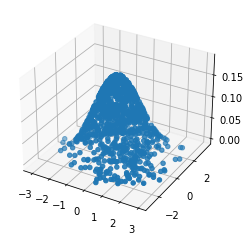

In [62]:
# 实现高斯分布

# d=2
def gaussian(mean, covariance, x):
    p = x - mean
    return 1.0 / (2.0 * np.pi) * np.sqrt(1.0 / np.linalg.det(covariance)) * np.exp(-0.5 * np.matmul(np.matmul(p.T, np.linalg.inv(covariance)), p))

def test_gaussian():
    cov = np.array([[1, 0.5], [0.5, 1]])
    mean = np.array([[0.0], [0.0]])
    points = []
    z = []
    for i in range(0, 1000):
        points.append(np.random.randn(2, 1))
        z.append(gaussian(mean, cov, points[-1])[0][0])
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.scatter3D([x[0][0] for x in points], [y[1][0] for y in points], z)
    plt.show()
    
test_gaussian()

In [43]:
# 基于高斯混合模型的分布聚类
# 先生成一堆基于高斯分布的点
clusters_gmm = 3
n_points = 2000
n_outliers = int(n_points / 10)
points = np.zeros((n_points, 2))
n_chunk = int((n_points - n_outliers) / 3)
centers = []
for i in range(0, clusters_gmm):
    while True:
        center = np.random.randn(1, 2)
        for c in centers:
            if np.linalg.norm(center - c) < 2.0:
                break
        else:
            centers.append(center)
            break
    for j in range(0, n_chunk):
        # 随机生成一个方向和距离
        dist = (np.random.rand() * 2.0 - 1.0) * 1.0
        direction = np.random.randn(1, 2)
        direction /= np.linalg.norm(direction)
        points[i * n_chunk + j] = center + dist * direction
for i in range(0, n_outliers):
    points[clusters_gmm * n_chunk + i] = np.random.randn(1, 2)

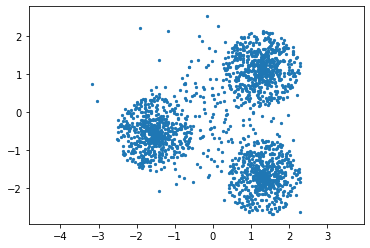

In [44]:
plt.axis("equal")
plt.scatter(points[:, 0], points[:, 1], s=5.0)

In [45]:
# 高斯分布模型：假设有 k 个类，也就是存在 k 个高斯分布。
# 每个高斯分布都有自己的均值和方差，根据均值和方差来计算每一个点属于这个类的概率。
# 一开始均值和方差是随机的，但是根据期望最小化（Expectation-Minimization），均值和方差可以逐渐被改到正确的位置。

k = 3
# 用列向量算了
means = np.zeros((2, k))
# 初始化高斯分布均值（中心） - 随便挑一个点
for i in range(0, k):
    pick = np.random.randint(points.shape[0])
    means[:, i] = points[pick]
    
comps = np.full((1, k), 1.0 / k)

# 计算初始的协方差
mean_pt = points.sum(0) / points.shape[0]
cov = np.zeros((2, 2))
for p in points:
    offset = np.array([p - mean_pt])
    cov += np.matmul(offset.T, offset)
cov /= points.shape[0]
covariances = [cov for _ in range(0, k)]
    
p_clusters = np.full((1, n_points), -1)
gammas = np.zeros((n_points, k))

# 1. 计算每一个点在这个当前高斯分布当中的概率，储存在 gamma 表当中。
# 2. 通过当前聚类的 gamma 列来决定新的权重分布。
# 3. 通过求出每个聚类的带权（高斯分布概率）均值和协方差，决定该分布的新位置。
# 4. 重复直到满意为止
for _ in range(0, 10):
    for i, p in enumerate(points):
        chances = np.zeros((k, 1))
        for cluster in range(0, k):
            chances[cluster, 0] = comps[0, cluster] * gaussian(means[:, cluster][:, np.newaxis], covariances[cluster], p[:, np.newaxis])
        for cluster in range(0, k):
            this_chance = chances[cluster, 0] / chances.sum()
            gammas[i, cluster] = this_chance
    gammas_sum = gammas.sum(0)
    comps = gammas_sum[:, np.newaxis].T / points.shape[0]
    means = np.matmul(gammas.T, points).T / gammas_sum
    for cluster in range(0, k):
        cov = np.zeros((2, 2))
        for i, p in enumerate(points):
            offset = gammas[i, cluster] * np.array([p - means[:, cluster]])
            cov += np.matmul(offset.T, offset)
        cov /= gammas_sum[cluster]
        covariances[cluster] = cov
        
# 谁概率大直接选谁
for i, p in enumerate(points):
    chances = np.zeros((k, 1))
    for cluster in range(0, k):
        chances[cluster, 0] = gaussian(means[:, cluster], covariances[cluster], p.T)
    chances = chances / chances.sum()
    pick = np.argmax(chances)
    p_clusters[0, i] = pick

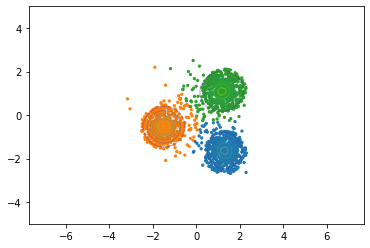

In [46]:
# 画出结果
primitive_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#1a437b", "#426f7c", "#381a90", "#1f1f21"]
colors = [primitive_colors[int(x)] for x in p_clusters.flatten()]

fig, ax = plt.subplots()
ax.axis("equal")
ax.scatter(points[:, 0], points[:, 1], s=5.0, c=colors)

for i in range(0, k):
    cov_inv = np.linalg.inv(covariances[i])
    cov_det = np.linalg.det(covariances[i])
    m = means[:, i]
    x = np.linspace(-5, 5)
    y = np.linspace(-5, 5)
    X, Y = np.meshgrid(x,y)
    coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
    Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))

    ax.contour(X, Y, Z, alpha=0.3)
plt.show()

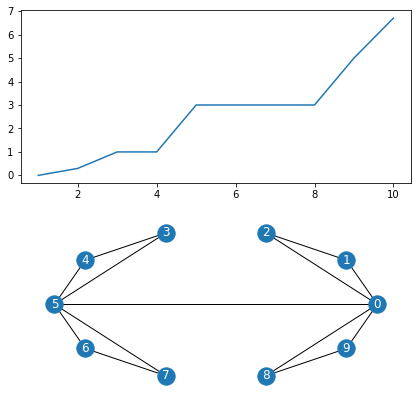

In [77]:
# 先生成一个随机的邻接矩阵，要来做谱聚类
n_points = 10
adjacency_mat = np.random.randint(0, 100, (n_points, n_points))
# 对称化掉
for i in range(0, adjacency_mat.shape[0]):
    adjacency_mat[i, i] = 0
    for j in range(i + 1, adjacency_mat.shape[1]):
        if adjacency_mat[i, j] < 70:
            adjacency_mat[i, j] = 0
        else:
            adjacency_mat[i, j] = 1
        adjacency_mat[j, i] = adjacency_mat[i, j]
        
adjacency_mat = np.array([
    [0., 1., 1., 0., 0., 1., 0., 0., 1., 1.],
    [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
    [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
    [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
    [1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
    [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
    [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
    [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

degrees_mat = np.diag(adjacency_mat.sum(0))
laplacian_mat = degrees_mat - adjacency_mat
eigenvalues, eigenvectors = np.linalg.eig(laplacian_mat)
eigenvectors_sorted = eigenvectors[np.argsort(eigenvalues)]
eigenvectors = eigenvectors[:, np.argsort(eigenvalues)]
eigenvalues = eigenvalues[np.argsort(eigenvalues)]

fig, ax = plt.subplots(2, 1)
fig.set_figwidth(7)
fig.set_figheight(7)
g = nx.Graph(adjacency_mat)
nx.draw_circular(g, with_labels=True, font_color="#ffffff")
sorted_eigenvalues = np.sort(eigenvalues)
ax[0].plot(np.arange(1, len(eigenvalues) + 1), sorted_eigenvalues)
plt.show()

费德勒值： 0.29843788128357546
费德勒向量： [ 0.11702863  0.15811388  0.31622777 -0.33362299 -0.25727796 -0.09621369
 -0.14692673 -0.49958416  0.20638004  0.22379339]


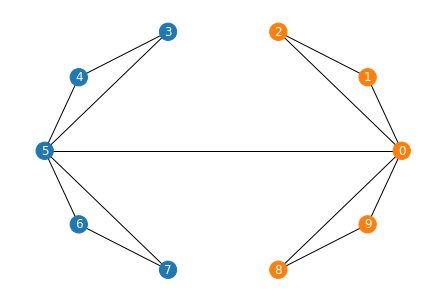

In [78]:
fiedler = eigenvalues[1]
fiedler_vec = eigenvectors_sorted[1]
print("费德勒值：", fiedler)
print("费德勒向量：", fiedler_vec)

labels = [0 if x < 0 else 1 for x in fiedler_vec]
color_map = ["#1f77b4" if x == 0 else "#ff7f0e" for x in labels]
nx.draw_circular(g, node_color=color_map, with_labels=True, font_color="#ffffff")

In [87]:
# 使用 k-means 进行谱聚类
# 1. 先找一个大跳（上一个的特征值和下一个的特征值相差超过阈值）
# 2. 通过这个来决定分的区间数量
# 3. 通进 k-means 算法中

threshold = 1.3
nonzero_index = 0
for i in range(1, len(eigenvalues)):
    if eigenvalues[i] < epsilon:
        nonzero_index += 1
    if eigenvalues[i] - eigenvalues[i - 1] > threshold:
        break
else:
    print("错误! 图好像并没有联通。")

# K-均值法
clusters_centroid = i
dims = clusters_centroid - nonzero_index 
p_clusters = np.zeros((n_points, 1))
points = eigenvectors[:, nonzero_index:clusters_centroid]
centroids = points[0:clusters_centroid] + np.random.randn(clusters_centroid, dims) * 0.01

for i in range(0, 100):
    # 用来追踪啥时候该停止
    stop_counter = 0
    
    for p_idx, p in enumerate(points):
        closest_dist = 0
        closest_idx = -1
        for k_idx, k in enumerate(centroids):
            dist = np.linalg.norm(p - k)
            if closest_idx == -1 or dist < closest_dist:
                closest_dist = dist
                closest_idx = k_idx
        if closest_idx == -1:
            raise Error("错误! 有个点没有分到类")
        p_clusters[p_idx] = closest_idx

    # 计算新的中心点位
    for k_idx, k in enumerate(centroids):
        points_k = points[(p_clusters == k_idx).flatten()]
        # 检查是不是有中心点没分到点
        if len(points_k) == 0:
            centroids[k_idx, :] = points[np.random.randint(len(points))]
            break
        new_centroid = np.zeros((1, dims))
        for p in points_k:
            new_centroid += p
        new_centroid /= len(points_k)

        # 检查中心点是不是接近不变
        if np.linalg.norm(new_centroid - k) < epsilon:
            stop_counter += 1
        centroids[k_idx] = new_centroid
        
    if stop_counter == len(centroids):
        break

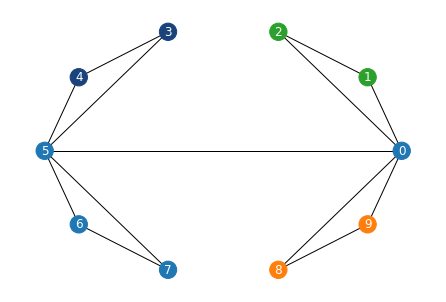

In [88]:
primitive_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#1a437b", "#426f7c", "#381a90", "#1f1f21"]
color_map = [primitive_colors[int(x[0])] for x in p_clusters]
nx.draw_circular(g, node_color=color_map, with_labels=True, font_color="#ffffff")

In [191]:
# 样例数据集 - seeds_data
# 面积，周长，紧密度，籽粒长度，籽粒宽度，不对称系数，仁槽长度，分类

fd = open("seeds_dataset.txt", "r")
lines = fd.readlines()
fd.close()
num_cols = len(lines[0].split("\t"))
data = np.zeros((len(lines), num_cols - 1))
ans = np.zeros((len(lines), 1))
for i, line in enumerate(lines):
    items = re.split("\t+", line)
    for j, item in enumerate(items):
        if j == len(items) - 1:
            ans[i, 0] = float(item) - 1.0
        else:
            data[i, j] = float(item)

In [192]:
# K-均值法
clusters_centroid = 3
dims = num_cols - 1
# seed_index = np.random.randint(len(lines) - clusters_centroid)
seed_index = 57
print("选", seed_index, "作为种子点")
centroids = data[seed_index:seed_index + clusters_centroid]
n_data = data.shape[0]
p_clusters = np.zeros((n_data, 1))

for i in range(0, 1):
    # 用来追踪啥时候该停止
    stop_counter = 0
    
    for p_idx, p in enumerate(data):
        closest_dist = 0
        closest_idx = -1
        for k_idx, k in enumerate(centroids):
            dist = np.linalg.norm(p - k)
            if closest_idx == -1 or dist < closest_dist:
                closest_dist = dist
                closest_idx = k_idx
        if closest_idx == -1:
            raise Error("错误! 有个点没有分到类")
        p_clusters[p_idx] = closest_idx

    # 计算新的中心点位
    for k_idx, k in enumerate(centroids):
        data_k = data[(p_clusters == k_idx).flatten()]
        # 检查是不是有中心点没分到点
        if len(data_k) == 0:
            centroids = np.random.randn(clusters_centroid, dims)
            break
        new_centroid = np.zeros((1, dims))
        for p in data_k:
            new_centroid += p
        new_centroid /= len(data_k)
        # 检查中心点是不是接近不变
        if np.linalg.norm(new_centroid - k) < epsilon:
            stop_counter += 1
        centroids[k_idx] = new_centroid
        
    if stop_counter == len(centroids):
        break

print("准确率：", (p_clusters == ans).sum() / data.shape[0])

选 57 作为种子点
准确率： 0.7095238095238096


In [234]:
# DBSCAN
# k = 0 代表离群
k = 0
labels = np.zeros((n_data, 1))
core_req = 4
delta = 0.8

def get_neighbors(p1, dist_req):
    dists = np.array([np.linalg.norm(p1 - p2) for p2 in data])
    ret = dists < dist_req
    return np.where(ret)[0]

# 1. 如果有标签，跳过
# 2. 如果没有标签，查找邻居 - 是不是在 core_req 个邻居以内（包括自身）?
# 3. 如果是，检查邻居的邻居，是否满足 core_req。如果是，把邻居的邻居也加到检查列表当中。
# 4. 一直循环直到满足这些为止。
for i, p in enumerate(data):
    if labels[i] != 0:
        continue
    neighbors = get_neighbors(p, delta)
    if len(neighbors) >= core_req:
        k += 1
        labels[i] = k
        while len(neighbors) > 0:
            neighbor = neighbors[0]
            neighbors = np.delete(neighbors, 0)
            if neighbor == i or labels[neighbor] != 0:
                continue
            labels[neighbor] = k
            neighbors_neighbors = get_neighbors(data[neighbor], delta)
            if len(neighbors_neighbors) >= core_req:
                neighbors = np.union1d(neighbors, neighbors_neighbors)

tags = []
for label in labels:
    if label == 1.0:
        tags.append(3.0)
    elif label == 3.0:
        tags.append(1.0)
    elif label == 5.0:
        tags.append(2.0)
    elif label == 2.0:
        tags.append(5.0)
    else:
        tags.append(label[0])

print("准确率：", (np.array(tags)[:, np.newaxis] == (ans + 1.0)).sum() / data.shape[0])

准确率： 0.5523809523809524


In [251]:
# 样例数据集 - wine.data
# 分类，酒精，苹果酸，灰烬，灰的碱性，镁，总酚，类黄酮，非黄酮类酚类，原花青素，颜色强度，色调，OD280，脯氨酸

fd = open("wine.data", "r")
lines = fd.readlines()
fd.close()
num_cols = len(lines[0].split(","))
dims = num_cols - 1
data = np.zeros((len(lines), num_cols - 1))
ans = np.zeros((len(lines), 1))
n_data = len(lines)
for i, line in enumerate(lines):
    items = line.split(",")
    for j, item in enumerate(items):
        if j == 0:
            ans[i, 0] = float(item)
        else:
            data[i, j - 1] = float(item)

In [264]:
# 要变成 n 维的高斯
def gaussian(mean, covariance, x):
    p = x - mean
    return 1.0 / (2.0 * np.pi) * np.sqrt(1.0 / np.linalg.det(covariance)) * np.exp(-0.5 * np.matmul(np.matmul(p.T, np.linalg.inv(covariance)), p))

k = 3
# 用列向量算了
means = np.zeros((dims, k))
# 初始化高斯分布均值（中心） - 随便挑一个点
for i in range(0, k):
    pick = np.random.randint(data.shape[0])
    means[:, i] = data[pick]
    
comps = np.full((1, k), 1.0 / k)

# 计算初始的协方差
mean_pt = data.sum(0) / data.shape[0]
cov = np.zeros((dims, dims))
for p in data:
    offset = np.array([p - mean_pt])
    cov += np.matmul(offset.T, offset)
cov /= data.shape[0]
covariances = [cov for _ in range(0, k)]
    
p_clusters = np.full((1, n_data), -1)
gammas = np.zeros((n_data, k))

# 1. 计算每一个点在这个当前高斯分布当中的概率，储存在 gamma 表当中。
# 2. 通过当前聚类的 gamma 列来决定新的权重分布。
# 3. 通过求出每个聚类的带权（高斯分布概率）均值和协方差，决定该分布的新位置。
# 4. 重复直到满意为止
for _ in range(0, 20):
    for i, p in enumerate(data):
        chances = np.zeros((k, 1))
        for cluster in range(0, k):
            chances[cluster, 0] = comps[0, cluster] * gaussian(means[:, cluster][:, np.newaxis], covariances[cluster], p[:, np.newaxis])
        for cluster in range(0, k):
            this_chance = chances[cluster, 0] / chances.sum()
            gammas[i, cluster] = this_chance
    gammas_sum = gammas.sum(0)
    comps = gammas_sum[:, np.newaxis].T / data.shape[0]
    means = np.matmul(gammas.T, data).T / gammas_sum
    for cluster in range(0, k):
        cov = np.zeros((dims, dims))
        for i, p in enumerate(data):
            offset = gammas[i, cluster] * np.array([p - means[:, cluster]])
            cov += np.matmul(offset.T, offset)
        cov /= gammas_sum[cluster]
        covariances[cluster] = cov
        
# 谁概率大直接选谁
for i, p in enumerate(data):
    chances = np.zeros((k, 1))
    for cluster in range(0, k):
        chances[cluster, 0] = gaussian(means[:, cluster], covariances[cluster], p.T)
    chances = chances / chances.sum()
    pick = np.argmax(chances)
    p_clusters[0, i] = pick

In [269]:
tags = []
for label in p_clusters.T:
    label = label[0]
    if label == 2:
        tags.append(1)
    elif label == 0:
        tags.append(2)
    else:
        tags.append(3)

print("准确率：", (np.array(tags)[:, np.newaxis] == ans).sum() / data.shape[0])

准确率： 0.6348314606741573
